# LSTM

Dans ce notebook, nous utilisons un modèle de réseau de neurones récurrents particulier, le **LSTM**. Voir [cet article](https://penseeartificielle.fr/comprendre-lstm-gru-fonctionnement-schema/) pour comprendre l'architecture du LSTM.
## Importer et préparer des données

La première étape est la même que dans le notebook précédent.

La seule différence est que nous définissons `include_lengths = True` pour notre champ `TEXT`. Cela fera que `batch.text` sera maintenant un tuple avec le premier élément étant notre phrase et le deuxième élément étant les longueurs réelles de nos phrases.

In [1]:
import pandas as pd
import torch
from torchtext import data
from torchtext import datasets
import random
# pour la reproductibilité
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(sequential=True,lower=True, tokenize = 'spacy', include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
test_data, valid_data = test_data.split(random_state = random.seed(1234))

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


## Vocabulaire



Vient ensuite l'utilisation de word embeding pré-entraînées. Maintenant, au lieu d'avoir nos embeddings de mots initialisés au hasard, ils sont initialisés avec ces vecteurs pré-entraînés. Nous obtenons ces vecteurs simplement en spécifiant quels vecteurs nous voulons et en les passant comme argument à `build_vocab`. `TorchText` gère le téléchargement des vecteurs et les associe aux mots corrects de notre vocabulaire.

Ici, nous allons utiliser les "vecteurs" glove.6B.100d. **GloVe** est l'algorithme utilisé pour calculer les vecteurs. 6B indique que ces vecteurs ont été entraînés sur 6 milliards de tokens et 100d indique que ces vecteurs sont 100 -dimensionnelle. Pour plus d'informations sur la représentation GloVe, lire [cet article](https://nlp.stanford.edu/projects/glove/).

In [2]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

## Itérateur

Ici tous les tenseurs d'un batch doivent être triés par leurs longueurs. Ceci est géré dans l'itérateur en définissant `sort_within_batch = True`.

In [3]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,sort_key=lambda x: len(x.text),
    sort_within_batch = True)

## Modèle

Dans ce modèle, on utilise le LSTM au lieu d'un RNN simple. En effet, les RNN standard souffrent du problème de disparition du gradient. Les LSTM surmontent ce problème en ayant un état récurrent supplémentaire appelé cellule, $c$  qui peut être considéré comme la «mémoire» du LSTM et en utilisant plusieurs portes (gates) qui contrôlent le flux d'informations dans et hors de la mémoire. Nous pouvons simplement considérer le LSTM comme une fonction de $x_t$, $h_t$ et $c_t$, au lieu de seulement $x_t$ et $h_t$. 
$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$
L'état initial de la cellule, $c_0$, comme l'état caché initial est initialisé à un tenseur égal à zéro. Cependant, la prédiction de sentiment n'est faite qu'en utilisant l'état caché final, c'est-à-dire $\hat {y} = f (h_T)$.

De plus ce modèle est :  
 - **Bidirectionnel** :  en plus d'avoir un modèle LSTM traitant les mots du commentaire du premier au dernier (LSTM forward), on introduit un second modèle LSTM traitant les mots du dernier au premier (LSTM backward). Au pas de temps $t$, le LSTM forward traite le mot $x_t$, et le LSTM backward traite le mot $x_ {T-t + 1}$. La prédiction du sentiment est réalisée en utilisant une concaténation du dernier état caché du LSTM forward (obtenu à partir du dernier mot de la phrase), $ h_T ^ \rightarrow $, et le dernier état caché du LSTM backward (obtenu à partir du premier mot de la phrase), $ h_T ^ \leftarrow $ on le donne à une couche $f$, pour recevoir notre sentiment prédit, $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$;
 - **Multi-couches** : nous ajoutons des LSTM supplémentaires en plus du LSTM standard initial, où chaque LSTM ajouté est une autre couche. La sortie d'état caché par le premier LSTM (inférieur) au pas de temps $t$ sera l'entrée du LSTM au-dessus de lui au pas de temps $ t $. La prédiction est alors faite à partir de l'état caché final de la couche finale (la plus haute).
 
On fait également de la **régularisation**. En effet, plus on a de paramètres dans notre modèle, plus la probabilité que notre modèle overfit est élevée (mémoriser les données d'entraînement, provoquant une erreur d'entraînement faible mais une erreur de validation / test élevée, c'est-à-dire une mauvaise généralisation à de nouveaux exemples). Pour lutter contre cela, nous utilisons la régularisation. Plus précisément, nous utilisons une méthode de régularisation appelée **dropout**. Le dropout fonctionne en supprimant aléatoirement (mise à 0) les neurones dans une couche lors d'un passage vers l'avant.

Enfin, avant de transmettre les embeddings au LSTM, nous devons faire du padding, c'est-à-dire faire en sorte que les séquences soient de mêmes longueurs au sein d'un même batch. Nous utilisons alors `nn.utils.rnn.packed_padded_sequence`.


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        embedded = self.dropout(self.embedding(text))    
        #embedded = [sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]   
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))           
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

Comme auparavant, nous allons créer une instance de notre classe RNN, avec les nouveaux paramètres et arguments pour le nombre de couches, la bidirectionnalité et la probabilité de dropout.
Pour garantir que les vecteurs pré-entraînés peuvent être chargés dans le modèle, `EMBEDDING_DIM` doit être égal à celui des vecteurs GloVe pré-entraînés chargés précédemment.

In [5]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 5,403,601 paramètres à entraîner


Le dernier ajout consiste à copier les embeddings de mots pré-entraînées que nous avons chargées précédemment dans la couche d'embedding de notre modèle.
Nous récupérons les embeddings à partir du vocabulaire de `Field` et vérifions qu'elles sont de la bonne taille, **[taille du vocabulaire,dim embedding]**

Comme nos tokens `<unk>` et `<pad>` ne sont pas dans le vocabulaire pré-entraîné, ils ont été initialisés en utilisant `unk_init` (une distribution $ \mathcal {N} (0,1) $) lors de la construction de notre vocabulaire. Il est préférable de les initialiser tous les deux à zéros pour indiquer explicitement à notre modèle que, au départ, ils ne sont pas pertinents pour déterminer le sentiment.


In [6]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Métriques

On utilise l'**accuracy** comme métrique.

In [7]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

## Optimiseur et fonction de perte

In [8]:
import torch.optim as optim

def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

## Entraîner le modèle

In [14]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        text, text_lengths = batch.text       
        predictions = model(text, text_lengths.to('cpu')).squeeze(1)
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()     
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            text, text_lengths = batch.text       
            predictions = model(text, text_lengths.to('cpu')).squeeze(1) 
            loss = criterion(predictions, batch.label)    

            acc = binary_accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 50

best_valid_loss = float('inf')
tloss = []
tacc = []
vloss = []
vacc = []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tloss.append(train_loss)
    tacc.append(train_acc)  
    
    scheduler.step()
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)     
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 0.408 | Train Acc: 82.45%
	 Val. Loss: 0.429 |  Val. Acc: 82.03%
Epoch: 02 | Epoch Time: 0m 50s
	Train Loss: 0.393 | Train Acc: 83.00%
	 Val. Loss: 0.392 |  Val. Acc: 83.95%
Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 0.382 | Train Acc: 83.63%
	 Val. Loss: 0.383 |  Val. Acc: 84.60%
Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 0.379 | Train Acc: 83.62%
	 Val. Loss: 0.364 |  Val. Acc: 84.83%
Epoch: 05 | Epoch Time: 0m 50s
	Train Loss: 0.366 | Train Acc: 84.51%
	 Val. Loss: 0.373 |  Val. Acc: 85.11%
Epoch: 06 | Epoch Time: 0m 50s
	Train Loss: 0.367 | Train Acc: 84.22%
	 Val. Loss: 0.367 |  Val. Acc: 85.07%
Epoch: 07 | Epoch Time: 0m 50s
	Train Loss: 0.362 | Train Acc: 84.64%
	 Val. Loss: 0.360 |  Val. Acc: 85.11%
Epoch: 08 | Epoch Time: 0m 51s
	Train Loss: 0.352 | Train Acc: 85.00%
	 Val. Loss: 0.359 |  Val. Acc: 85.41%
Epoch: 09 | Epoch Time: 0m 50s
	Train Loss: 0.354 | Train Acc: 84.89%
	 Val. Loss: 0.359 |  Val. Acc: 84.98%
Epoch: 10 | Epoch T

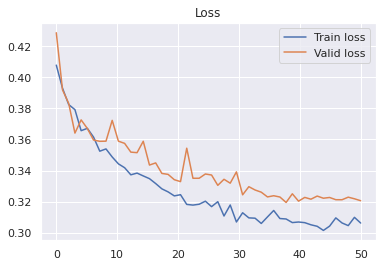

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

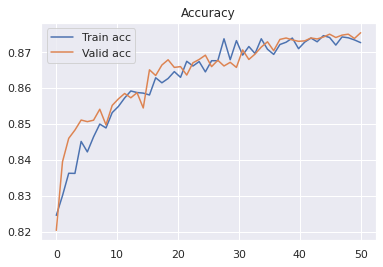

In [16]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

Les hyperparamètres choisis sont : 


|Embedding dim|Hidden dim|Learning rate|Number of layers|Dropout|
|-------------|----------|-------------|----------------|-------|
|100           | 100      | 1e-4        |   2            |  0.6  |


## Tester le modèle

In [17]:
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.332 | Test Acc: 86.85%


### Inférence

In [68]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    if (prediction.item() > 0.5):
      print ("Sentiment: Positive")
    else:
      print ("Sentiment: Negative")
    
predict_sentiment(model, "This film is great")

Sentiment: Positive


In [69]:
predict_sentiment(model, "This film is terrible")

Sentiment: Negative


In [70]:
predict_sentiment(model, "This film is not good at all")

Sentiment: Positive


Ce modèle donne de bons résultats (une accuracy de 0.87 sur l'échantillon test), par contre il n'arrive pas à prédire correctement la négation. Par exemple, le commentaire "This film is not good at all" est prédit comme étant positif alors qu'il ne l'est pas.


## Référence : 

 - https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb